# Learning and Evaluating a Probabilistic Circuit

In this notebook, we instantiate, learn, and evaluate a probabilistic circuit using ```cirkit```. The probabilistic circuit we build estimates the distribution of MNIST images, which is then evaluated on unseen images and used to compute marginal probabilities. Here, we focus on the simplest experimental setting, where we want to instantiate a probabilistic circuit for MNIST images using some hyperparameters of our own choice, such as the type of the layers, their size and how to parameterize them. Then, we learn the parameters of the circuit and perform inference using PyTorch.

A key feature of ```cirkit``` is the _symbolic circuit representation_, which allows us to abstract away from the underlying implementation choices. In the next section, we introduce this symbolic representation and show how to construct a symbolic circuit whose structure and parameterization is tailored for image data sets.

## Constructing the Symbolic Circuit

The **symbolic circuit** is a symbolic abstraction of a tensorized circuit, i.e., a circuit consisting of sum/product/input layers, each grouping several sum/product/input units, respectively. This symbolic representation stores the connections between the layers, the number of units in each layer, and useful metadata about the parameters, such as their shape and parameterization choices. Note that a symbolic circuit does not allocate parameters and cannot be used for learning or inference. By _compiling a symbolic circuit_ using PyTorch, we will later recover a probabilistic circuit that can be learned or be used for inference purposes.

In ```cirkit.templates```, we provide several templates that can be used to construct symbolic circuits of different structures. In this notebook, we use a high-level template to build a symbolic circuit specifically for image data. To do so, we need to specify some arguments that will possibly yield different architectures and parameterizations. That is, we specify the shape of the images, and select one of the region graphs that exploits the closeness of patches of pixels, such as the _QuadGraph_ region graph (see (TODO: ref) for more details). Moreover, we select the type of input and inner layers, the number of units within them, and how to parameterize the sum layers. See comments in the code below for more details about each argument.

In [1]:
from cirkit.templates import circuit_templates

symbolic_circuit = circuit_templates.image_data(
    (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
    region_graph='quad-graph',  # Select the structure of the circuit to follow the QuadGraph region graph
    input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
    num_input_units=64,         # Each input layer consists of 64 Categorical input units
    sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense sum layers and hadamard product layers
    num_sum_units=64,           # Each dense sum layer consists of 64 sum units
    sum_weight_param='softmax'  # Parameterize the weights of dense sum layers with 'softmax'
)

We can query some information regarding the symbolic circuit, such as the number of variables and channels it is defined on, and which structural properties it does satisfy.

In [2]:
# Print some information
print(f'Number of variables: {symbolic_circuit.num_variables}')
print(f'Number of channels per variable: {symbolic_circuit.num_channels}')
print()

# Print which structural properties the circuit satisfies
print(f'Structural properties:')
print(f'  - Smoothness: {symbolic_circuit.is_smooth}')
print(f'  - Decomposability: {symbolic_circuit.is_decomposable}')
print(f'  - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}')

Number of variables: 784
Number of channels per variable: 1

Structural properties:
  - Smoothness: True
  - Decomposability: True
  - Structured-decomposability: False


## Compiling the Symbolic Circuit with PyTorch

After we have built our symbolic circuit, it is necessary to **compile** it in order to learn the parameters and perform probabilistic inference. By default, cirkit compiles symbolic circuits using PyTorch 2+. More precisely, by compiling a symbolic circuit, we retrieve a tensorized circuit that specializes [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), thus being very similar to a neural network written in PyTorch. First, we set some random seeds and set the torch device we will use later.

In [3]:
import random
import numpy as np
import torch

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda')

Next, we import the ```compile``` function from the ```cirkit.pipeline``` module and compile our symbolic circuit.

In [4]:
%%time
from cirkit.pipeline import compile
circuit = compile(symbolic_circuit)

CPU times: user 1.98 s, sys: 95.4 ms, total: 2.08 s
Wall time: 2.14 s


Note that the compilation procedure took about three seconds for a circuit with >5700 layers and ~25M parameters, as shown below.

In [5]:
# Print some statistics
num_layers = len(list(symbolic_circuit.layers))
print(f"Number of layers: {num_layers}")
num_parameters = sum(p.numel() for p in circuit.parameters())
print(f"Number of learnable parameters: {num_parameters}")

Number of layers: 5723
Number of learnable parameters: 25641474


## Learning a Probabilistic Circuit using PyTorch

Learning the probabilistic circuit we have compiled above can be done in the same way as any other neural network written using PyTorch. In this notebook, we learn the parameters of the probabilistic circuit as to estimate the distribution of MNIST images. Therefore, below we load the MNIST data set using [torchvision](https://pytorch.org/vision/stable/index.html), and we instantiate the training and testing data loaders. In addition, we select one of the many optimizers implemented in PyTorch, such as [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [6]:
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Flatten the images and set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = optim.Adam(circuit.parameters(), lr=0.01)

Finally, we write a classical PyTorch training loop that iterates over batches of MNIST images for some epochs, and optimizes the parameters of the circuit by minimizing the negated average log-likelihood.

In [7]:
num_epochs = 5
step_idx = 0
running_loss = 0.0

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch, _) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device).unsqueeze(dim=1)

        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch)

        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        step_idx += 1
        if step_idx % 100 == 0:
            print(f"Step {step_idx}: Average NLL: {running_loss / (100 * len(batch)):.3f}")
            running_loss = 0.0

Step 100: Average NLL: 3413.503
Step 200: Average NLL: 1570.939
Step 300: Average NLL: 943.365
Step 400: Average NLL: 844.022
Step 500: Average NLL: 792.295
Step 600: Average NLL: 771.739
Step 700: Average NLL: 757.540
Step 800: Average NLL: 737.136
Step 900: Average NLL: 734.869
Step 1000: Average NLL: 719.217
Step 1100: Average NLL: 718.645


Similarly, we evaluate our probabilistic circuit on the test data by computing the average log-likelihood and bits per dimension.

In [8]:
with torch.no_grad():
    test_lls = 0.0

    for batch, _ in test_dataloader:
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device).unsqueeze(dim=1)

        # Compute the log-likelihoods of the batch
        log_likelihoods = circuit(batch)

        # Accumulate the log-likelihoods
        test_lls += log_likelihoods.sum().item()

    # Compute average test log-likelihood and bits per dimension
    average_ll = test_lls / len(data_test)
    bpd = -average_ll / (28 * 28 * np.log(2.0))
    print(f"Average test LL: {average_ll:.3f}")
    print(f"Bits per dimension: {bpd:.3f}")

Average test LL: -711.266
Bits per dimension: 1.309


## Performing Inference: computing marginal probabilities

We conclude the notebook by showing a simple example of performing probabilistic inference on the learned probabilistic circuit: computing marginal probabilities. More specifically, we show how to compute the marginal probability of the pixels on the right half side of the image, i.e.,
$$
p(\mathbf{x}_{\text{R}}) = \sum_{\mathbf{x}_{\text{L}}\in[0,255]^{28\times 14}} p(\mathbf{x}_{\text{R}}, \mathbf{x}_{\text{L}}),
$$
where $\mathbf{x}_{\text{R}}$ (resp. $\mathbf{x}_{\text{L}}$) denotes an assignment to the pixels on the right half side (resp. left half side) of the MNIST image, and the joint distribution $p(\mathbf{x}_{\text{R}}, \mathbf{x}_{\text{L}})$ is modelled by the probabilistic circuit we have learned above.

In order to compute a marginal probability, we need to _integrate the probabilistic circuit over a variables' subset_. Note that, with a slight abuse of terminology, we will refer to "integrate" to indicate also the case of finite discrete summations (e.g., as in the marginal probability above). In practice, we leverage the ```IntegrateQuery``` object provided by the PyTorch backend.

In [9]:
import itertools
from cirkit.utils.scope import Scope
from cirkit.backend.torch.queries import IntegrateQuery

# Build the scope to marginalize, i.e., the set integer ids of the variables that will be integrated over
vars_to_marginalize = Scope(j * 28 + i for j, i in itertools.product(range(28), range(28)) if i < 14)

# Instantiate the integrate query handler
marginal_query = IntegrateQuery(circuit)

The ```marginal_query``` object can then be used to compute marginal probabilities. We show an example below, where we compute the average marginal probability of right half side patches of test images in MNIST.

In [10]:
with torch.no_grad():
    test_marginal_lls = 0.0

    for batch, _ in test_dataloader:
        # The marginal circuit still expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel. However, only some of the variables will be 
        # effectively used in the feed-forward evaluation.
        batch = batch.to(device).unsqueeze(dim=1)

        # Compute the marginal log-likelihoods of the batch
        marginal_log_likelihoods = marginal_query(batch, integrate_vars=vars_to_marginalize)

        # Accumulate the marginal log-likelihoods
        test_marginal_lls += marginal_log_likelihoods.sum().item()
    
    # Compute average test marginal log-likelihood
    average_marginal_ll = test_marginal_lls / len(data_test)
    print(f"Average test marginal LL: {average_marginal_ll:.3f}")

Average test marginal LL: -392.290


## Sampling from the Circuit

To visualise the generative capabilities of the circuit, we can sample from it and plot the results. Note that the sampling operation returns samples from the leaves *and* samples from the corresponding mixtures.

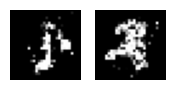

In [16]:
import einops as E
import matplotlib.pyplot as plt

from cirkit.backend.torch.queries import SamplingQuery

device = torch.device('cpu')
circuit = circuit.to(device)

num_samples = 1

sampling_query = SamplingQuery(circuit)
samples = sampling_query(num_samples=num_samples)

leaf_samples = samples[0]
mixtures_samples = samples[1]

leaf_samples = leaf_samples[:, 0, :] # Remove the channel dimension
samples = E.rearrange(leaf_samples, "n (h w) -> n h w", h=28, w=28)
samples = samples.cpu().numpy()

plt.figure(figsize=(num_samples, 1))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i], cmap="gray")
    plt.axis("off")
plt.show()